<a href="https://colab.research.google.com/github/devparikh0506/DATA-603/blob/main/assignment-3/Chicago_Crime_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType, BooleanType

Creating spark session

In [3]:
spark_session = SparkSession.builder.appName("ChicagoCrimeEDA").getOrCreate()
sc = spark_session.sparkContext

Defining schema

In [4]:
# For this data I'll define string types for numeric columns as well.
# Because the API i am using to get the JSON data is giving string values for all numeric columns.
# Later I will convert necessary columns to appropriate types

schema = StructType([
    StructField("id", StringType(), True),
    StructField("case_number", StringType(), True),
    StructField("date", StringType(), True),
    StructField("block", StringType(), True),
    StructField("iucr", StringType(), True),
    StructField("primary_type", StringType(), True),
    StructField("description", StringType(), True),
    StructField("location_description", StringType(), True),
    StructField("arrest", BooleanType(), True),
    StructField("domestic", BooleanType(), True),
    StructField("beat", StringType(), True),
    StructField("district", StringType(), True),
    StructField("ward", StringType(), True),
    StructField("community_area", StringType(), True),
    StructField("fbi_code", StringType(), True),
    StructField("x_coordinate", StringType(), True),
    StructField("y_coordinate", StringType(), True),
    StructField("year", StringType(), True),
    StructField("updated_on", StringType(), True),
    StructField("latitude", StringType(), True),
    StructField("longitude", StringType(), True),
    StructField("location", StringType(), True)
])

Loading data

In [5]:
!pip install sodapy

In [6]:
from sodapy import Socrata
import datetime

In [7]:
def load_chicago_crime_data_for_year(year : int , client , offset=0, limit=500_000):
  """
  Loads Chicago crime data for a given year.
  """
  try:
    results = client.get("ijzp-q8t2", limit=limit, offset=offset, year=year)
    if not (len(results) < limit):
      results += load_chicago_crime_data_for_year(year, client, offset=offset + limit, limit=limit)
    return results
  except Exception as e:
    print(f"Error loading data for year({year}):\n{e}")
    return []

def load_chicago_crime_data(limit=None):
    client = Socrata("data.cityofchicago.org", None)
    years = range(datetime.datetime.now().year, 2000, -1)
    loaded_data_count=0
    #  creating an empty dataframe
    emp_RDD = sc.emptyRDD()
    df = spark_session.createDataFrame(data = emp_RDD, schema = schema)
    for year in years:
        print(f"Loading data for year : {year}")
        data = load_chicago_crime_data_for_year(year, client)
        temp_df = spark_session.createDataFrame(data, schema)
        df = df.union(temp_df)
        temp_df_count = len(data)
        loaded_data_count += temp_df_count
        if limit and loaded_data_count >= limit:
            break
        print(f"Successfully loaded data for year({year}) =========> Data size : {temp_df_count}(rows)")
        temp_df.unpersist()

    print(f"Successfully loaded all data")
    return df

crime_df = load_chicago_crime_data()

Loading data for year : 2024
Successfully loaded data for year(2024) =========> Data size : 209572(rows)
Loading data for year : 2023
Successfully loaded data for year(2023) =========> Data size : 262599(rows)
Loading data for year : 2022
Successfully loaded all data


### Data cleaning

Removing null values

In [8]:
def print_null_report(df):
    print(df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show())

In [9]:
print_null_report(crime_df)

+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
| id|case_number|date|block|iucr|primary_type|description|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|updated_on|latitude|longitude|location|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|  0|          0|   0|    0|   0|           0|          0|                3183|     0|       0|   0|       0|  13|             0|       0|        5432|        5432|   0|         0|    5432|     5432|    5432|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+

In [10]:
crime_df = crime_df.na.drop("any")

In [11]:
crime_df.select([count(when(col(c).isNull(), c)).alias(c) for c in crime_df.columns]).show()

+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
| id|case_number|date|block|iucr|primary_type|description|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|updated_on|latitude|longitude|location|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|  0|          0|   0|    0|   0|           0|          0|                   0|     0|       0|   0|       0|   0|             0|       0|           0|           0|   0|         0|       0|        0|       0|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+

Converting columns to appropriate types

Especially converting date column to timestamp

In [12]:
crime_df = crime_df.withColumn("date", to_timestamp("date"))
crime_df = crime_df.withColumn("updated_on", to_timestamp("updated_on"))
crime_df = crime_df.withColumn("arrest", col("arrest").cast(BooleanType()))
crime_df = crime_df.withColumn("domestic", col("domestic").cast(BooleanType()))
crime_df = crime_df.withColumn("ward", col("ward").cast(IntegerType()))
crime_df = crime_df.withColumn("community_area", col("community_area").cast(IntegerType()))
crime_df = crime_df.withColumn("x_coordinate", col("x_coordinate").cast(DoubleType()))
crime_df = crime_df.withColumn("y_coordinate", col("y_coordinate").cast(DoubleType()))
crime_df = crime_df.withColumn("year", col("year").cast(IntegerType()))
crime_df = crime_df.withColumn("latitude", col("latitude").cast(DoubleType()))
crime_df = crime_df.withColumn("longitude", col("longitude").cast(DoubleType()))

In [13]:
crime_df.show(n=5)

+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+--------------------+
|      id|case_number|               date|               block|iucr|      primary_type|         description|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|         updated_on|    latitude|    longitude|            location|
+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+--------------------+
|13582916|   JH406913|2024-07-01 00:00:00|    102XX W ZEMKE RD|1206|DECEPTIVE PRACTICE|THEFT BY LESSEE, ...|AIRPORT EXTERIOR ...| false|

Filtering data for last ten years

In [14]:
crime_df_recent_ten_yrs = crime_df.filter(year(col("date")) >= year(current_date()) - 10)

Removing followin crime types

- 'NON-CRIMINAL (SUBJECT SPECIFIED)'
- 'OTHER OFFENSE'
- 'STALKING'
- 'NON - CRIMINAL'
- 'ARSON'

In [15]:
crime_df_recent_ten_yrs.select("primary_type").distinct().show(100, False)

+---------------------------------+
|primary_type                     |
+---------------------------------+
|OFFENSE INVOLVING CHILDREN       |
|CRIMINAL SEXUAL ASSAULT          |
|STALKING                         |
|PUBLIC PEACE VIOLATION           |
|OBSCENITY                        |
|ARSON                            |
|GAMBLING                         |
|CRIMINAL TRESPASS                |
|ASSAULT                          |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|THEFT                            |
|BATTERY                          |
|ROBBERY                          |
|HOMICIDE                         |
|PUBLIC INDECENCY                 |
|HUMAN TRAFFICKING                |
|INTIMIDATION                     |
|PROSTITUTION                     |
|DECEPTIVE PRACTICE               |
|CONCEALED CARRY LICENSE VIOLATION|
|SEX OFFENSE                      |
|CRIMINAL DAMAGE                  |
|NARCOTICS                        |
|NON-CRIMINAL               

In [16]:
excluded_crime_types = ['NON-CRIMINAL (SUBJECT SPECIFIED)', 'OTHER OFFENSE', 'STALKING', 'NON-CRIMINAL', 'ARSON']
crime_df_filtered = crime_df_recent_ten_yrs.filter(~col("primary_type").isin(excluded_crime_types))

In [17]:
crime_df_filtered.select("primary_type").distinct().show(100, False)

+---------------------------------+
|primary_type                     |
+---------------------------------+
|OFFENSE INVOLVING CHILDREN       |
|CRIMINAL SEXUAL ASSAULT          |
|PUBLIC PEACE VIOLATION           |
|OBSCENITY                        |
|GAMBLING                         |
|CRIMINAL TRESPASS                |
|ASSAULT                          |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|THEFT                            |
|BATTERY                          |
|ROBBERY                          |
|HOMICIDE                         |
|PUBLIC INDECENCY                 |
|HUMAN TRAFFICKING                |
|INTIMIDATION                     |
|PROSTITUTION                     |
|DECEPTIVE PRACTICE               |
|CONCEALED CARRY LICENSE VIOLATION|
|SEX OFFENSE                      |
|CRIMINAL DAMAGE                  |
|NARCOTICS                        |
|KIDNAPPING                       |
|BURGLARY                         |
|WEAPONS VIOLATION          

Merging similar crime types into one crime

In [18]:
similar_crime_types = {
    "SEXUAL CRIME" : ['CRIMINAL SEXUAL ASSAULT', 'SEX OFFENSE', 'PROSTITUTION'],
    "DRUG  CRIME" : ['NARCOTICS', 'OTHER NARCOTIC VIOLATION'],
    "THEFT AND FRAUD" : ["MOTOR VEHICLE THEFT", "THEFT", "DECEPTIVE PRACTICE"],
    "WEAPONS AND INTIMIDATION" : ["INTIMIDATION", "CONCEALED CARRY LICENSE VIOLATION", "WEAPONS VIOLATION", "INTERFERENCE WITH PUBLIC OFFICER"],
    "PUBLIC ORDER CRIME" : ["PUBLIC PEACE VIOLATION", "OBSCENITY", "GAMBLING", "LIQUOR LAW VIOLATION"]
}

for new_crime_type, old_crime_types in similar_crime_types.items():
    crime_df_filtered = crime_df_filtered.withColumn("primary_type", when(col("primary_type").isin(old_crime_types), new_crime_type).otherwise(col("primary_type")))

crime_df_filtered.select("primary_type").distinct().show(100, False)

+--------------------------+
|primary_type              |
+--------------------------+
|SEXUAL CRIME              |
|OFFENSE INVOLVING CHILDREN|
|PUBLIC ORDER CRIME        |
|CRIMINAL TRESPASS         |
|ASSAULT                   |
|DRUG  CRIME               |
|BATTERY                   |
|THEFT AND FRAUD           |
|ROBBERY                   |
|HOMICIDE                  |
|PUBLIC INDECENCY          |
|HUMAN TRAFFICKING         |
|WEAPONS AND INTIMIDATION  |
|CRIMINAL DAMAGE           |
|KIDNAPPING                |
|BURGLARY                  |
+--------------------------+



### Data analysis

1. Year-wise trend of the crime

In [27]:
from matplotlib import pyplot as plt

In [19]:
year_trend = crime_df_filtered.groupBy("Year").count().orderBy("Year")
year_trend.show()

+----+------+
|Year| count|
+----+------+
|2022|219012|
|2023|243892|
|2024|194139|
+----+------+



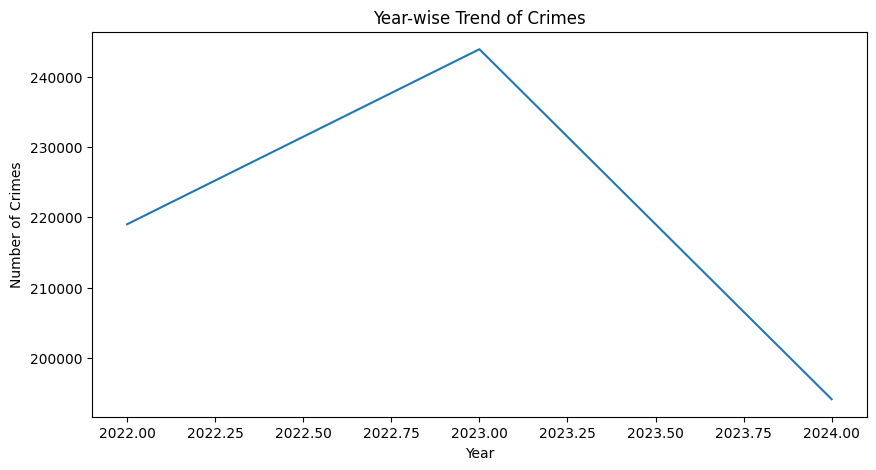

In [39]:
plt.figure(figsize=(10, 5))
year_trend_df = year_trend.toPandas()
plt.plot(year_trend_df['Year'], year_trend_df['count'])
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.title("Year-wise Trend of Crimes")
plt.show()

Let's find which hour of the day crime is highest

In [63]:
hourly_crime = crime_df_filtered.withColumn("Hour", hour("Date")).groupBy("Hour").count().orderBy(desc("count"))
print(hourly_crime.show(1))
print(f"Highest crime hour is : {hourly_crime.first()['Hour']}")

+----+-----+
|Hour|count|
+----+-----+
|   0|48325|
+----+-----+
only showing top 1 row

None
Highest crime hour is : 0


In [65]:
crime_df_top_ten = crime_df_filtered.groupBy("primary_type").count().orderBy(desc("count")).limit(10)
crime_df_top_ten.show()

+--------------------+------+
|        primary_type| count|
+--------------------+------+
|     THEFT AND FRAUD|270060|
|             BATTERY|122638|
|     CRIMINAL DAMAGE| 80357|
|             ASSAULT| 62695|
|             ROBBERY| 27446|
|WEAPONS AND INTIM...| 26718|
|            BURGLARY| 21608|
|         DRUG  CRIME| 13953|
|   CRIMINAL TRESPASS| 12848|
|        SEXUAL CRIME|  8559|
+--------------------+------+



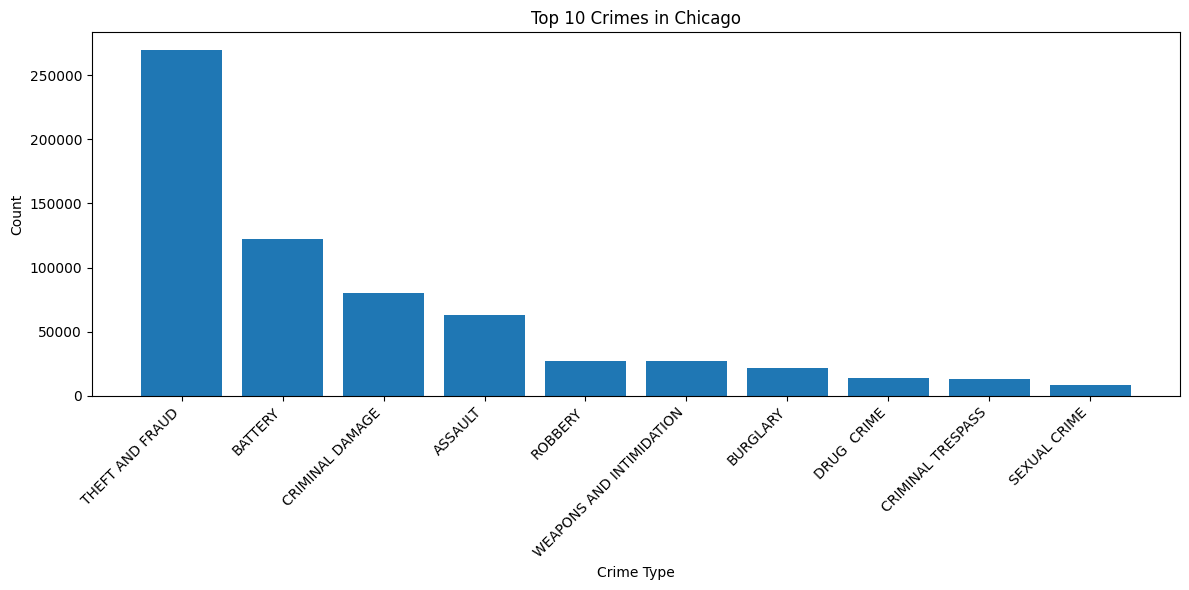

In [70]:
crime_df_top_ten_pd  = crime_df_top_ten.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(crime_df_top_ten_pd["primary_type"], crime_df_top_ten_pd["count"])
plt.title("Top 10 Crimes in Chicago")
plt.xlabel("Crime Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()